In [461]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [462]:
data = pd.read_csv('data/Bodegraven.csv')
data = data[data['transformator'] == ' TR2']
print(data)
data['hist_timestamp'] = pd.to_datetime(data['hist_timestamp'])
data.index = np.arange(len(data))
data.head()

                 hist_timestamp  avg_value  max_value  min_value     locatie  \
1      2024-07-24T11:15:00.000Z       8.00        8.0        8.0  Bodegraven   
3      2024-07-24T11:30:00.000Z       8.00        8.0        8.0  Bodegraven   
4      2024-07-24T11:45:00.000Z       8.00        8.0        8.0  Bodegraven   
6      2024-07-24T12:00:00.000Z       8.00        8.0        8.0  Bodegraven   
9      2024-07-24T12:15:00.000Z       8.00        8.0        8.0  Bodegraven   
...                         ...        ...        ...        ...         ...   
28220  2024-12-18T11:30:00.000Z       9.00        9.0        9.0  Bodegraven   
28222  2024-12-18T11:45:00.000Z       8.46        9.0        8.0  Bodegraven   
28224  2024-12-18T12:00:00.000Z       8.00        8.0        8.0  Bodegraven   
28227  2024-12-18T12:15:00.000Z       8.00        8.0        8.0  Bodegraven   
28228  2024-12-18T12:30:00.000Z       8.00        8.0        8.0  Bodegraven   

      spanning(kV) transformator  
1   

,hist_timestamp,avg_value,max_value,min_value,locatie,spanning(kV),transformator
0,2024-07-24 11:15:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2
1,2024-07-24 11:30:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2
2,2024-07-24 11:45:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2
3,2024-07-24 12:00:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2
4,2024-07-24 12:15:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2


In [463]:
data['jumps'] = np.abs(np.sign(data['avg_value'].diff()).diff())
data.loc[data['jumps'] == 2,'jumps'] = 1
data.loc[np.sign(data['avg_value'].diff()) == 0,'jumps'] = 0
if data['avg_value'].iloc[0] != data['avg_value'].iloc[1]:
    data.loc[1,'jumps'] = 1
else:
    data.loc[1,'jumps'] = 0
data.loc[0,'jumps'] = 0
data['number_tap_changes'] = np.cumsum(data['jumps'])

In [464]:
data.head()

,hist_timestamp,avg_value,max_value,min_value,locatie,spanning(kV),transformator,jumps,number_tap_changes
0,2024-07-24 11:15:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2,0.0,0.0
1,2024-07-24 11:30:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2,0.0,0.0
2,2024-07-24 11:45:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2,0.0,0.0
3,2024-07-24 12:00:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2,0.0,0.0
4,2024-07-24 12:15:00+00:00,8.0,8.0,8.0,Bodegraven,50-10,TR2,0.0,0.0


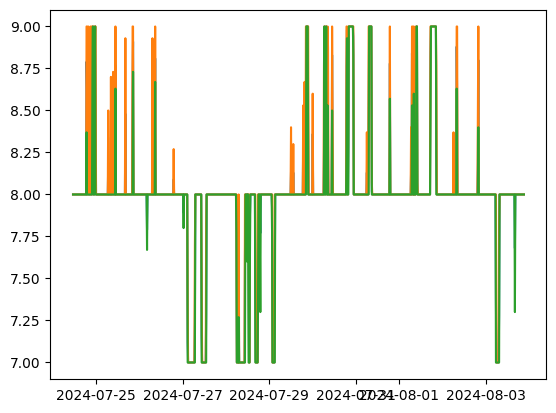

In [465]:
data_part = data.iloc[:1000]
plt.plot(data_part['hist_timestamp'],data_part['avg_value'])
plt.plot(data_part['hist_timestamp'],data_part['max_value'])
plt.plot(data_part['hist_timestamp'],data_part['min_value'])
plt.show()

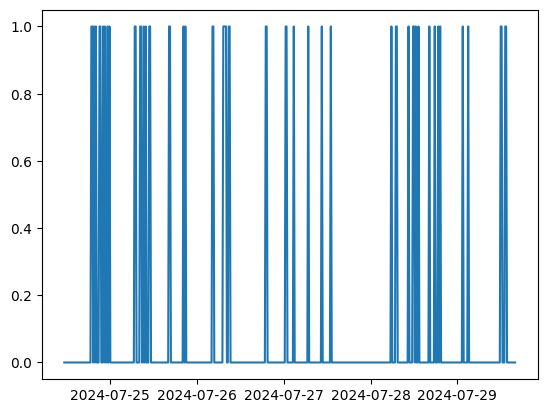

In [466]:
data_part = data.iloc[:500]
plt.plot(data_part['hist_timestamp'],data_part['jumps'])
plt.show()

In [467]:
data.describe()

,avg_value,max_value,min_value,jumps,number_tap_changes
count,14115.000000,14115.000000,14115.000000,14115.000000,14115.000000
mean,8.034775,8.078150,7.990003,0.162310,1147.797166
std,0.427531,0.454817,0.431204,0.368748,691.023316
min,7.000000,7.000000,7.000000,0.000000,0.000000
25%,8.000000,8.000000,8.000000,0.000000,540.000000
50%,8.000000,8.000000,8.000000,0.000000,1192.000000
75%,8.000000,8.000000,8.000000,0.000000,1740.000000
max,9.000000,9.000000,9.000000,1.000000,2291.000000


coefficients [-47.96208897   0.169443  ]


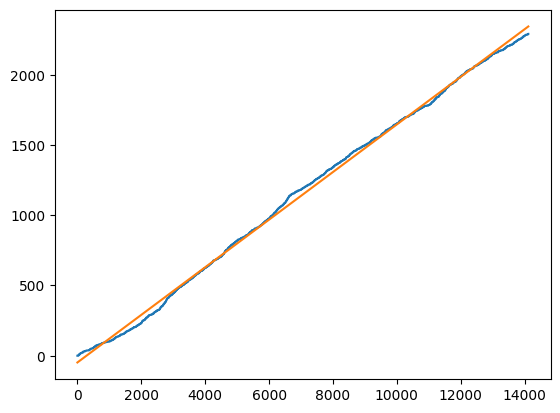

In [468]:
X = np.array([data.index])
X = np.concat((np.array([[1]*len(data)]),X),axis=0).T
Y = data['number_tap_changes']
beta = np.linalg.inv(X.T @ X) @ X.T @ Y
print('coefficients',beta)
plt.plot(data.index,Y)
plt.plot(data.index,X @ beta)
plt.show()

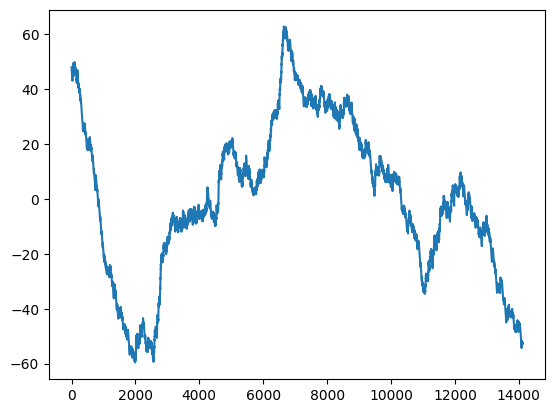

In [469]:
plt.plot(data.index,Y - X @ beta)
plt.show()

In [470]:
from prophet import Prophet
m = Prophet()
prophet_data = data.copy()
prophet_data.rename(columns={'number_tap_changes':'y','hist_timestamp':'ds'},inplace=True)
prophet_data['test'] = prophet_data['y'].iloc[1:]
prophet_data.loc[0,'test'] = 0 

prophet_data.iloc[-300:]
print(prophet_data)

def remove_timezone(dt):
   
    # HERE `dt` is a python datetime 
    # object that used .replace() method
    return dt.replace(tzinfo=None)
 
# APPLY THE ABOVE FUNCTION TO
# REMOVE THE TIMEZONE INFORMATION
# FROM EACH RECORD OF TIMESTAMP COLUMN IN DATAFRAME
prophet_data['ds'] = prophet_data['ds'].apply(remove_timezone)

m.fit(prophet_data)  # df is a pandas.DataFrame with 'y' and 'ds' columns
prediction = m.predict(prophet_data)
prediction.head()


                             ds  avg_value  max_value  min_value     locatie  \
0     2024-07-24 11:15:00+00:00       8.00        8.0        8.0  Bodegraven   
1     2024-07-24 11:30:00+00:00       8.00        8.0        8.0  Bodegraven   
2     2024-07-24 11:45:00+00:00       8.00        8.0        8.0  Bodegraven   
3     2024-07-24 12:00:00+00:00       8.00        8.0        8.0  Bodegraven   
4     2024-07-24 12:15:00+00:00       8.00        8.0        8.0  Bodegraven   
...                         ...        ...        ...        ...         ...   
14110 2024-12-18 11:30:00+00:00       9.00        9.0        9.0  Bodegraven   
14111 2024-12-18 11:45:00+00:00       8.46        9.0        8.0  Bodegraven   
14112 2024-12-18 12:00:00+00:00       8.00        8.0        8.0  Bodegraven   
14113 2024-12-18 12:15:00+00:00       8.00        8.0        8.0  Bodegraven   
14114 2024-12-18 12:30:00+00:00       8.00        8.0        8.0  Bodegraven   

      spanning(kV) transformator  jumps

20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-24 11:15:00,1.212182,-6.531575,9.664715,1.212182,1.212182,0.641360,0.641360,0.641360,0.232387,0.232387,0.232387,0.408974,0.408974,0.408974,0.0,0.0,0.0,1.853542
1,2024-07-24 11:30:00,1.333667,-6.165243,9.872843,1.333667,1.333667,0.649667,0.649667,0.649667,0.226167,0.226167,0.226167,0.423500,0.423500,0.423500,0.0,0.0,0.0,1.983335
2,2024-07-24 11:45:00,1.455152,-5.373773,10.400343,1.455152,1.455152,0.658656,0.658656,0.658656,0.220529,0.220529,0.220529,0.438127,0.438127,0.438127,0.0,0.0,0.0,2.113808
3,2024-07-24 12:00:00,1.576638,-5.710079,10.108934,1.576638,1.576638,0.669529,0.669529,0.669529,0.216676,0.216676,0.216676,0.452853,0.452853,0.452853,0.0,0.0,0.0,2.246167
4,2024-07-24 12:15:00,1.698123,-5.029662,10.830192,1.698123,1.698123,0.683040,0.683040,0.683040,0.215363,0.215363,0.215363,0.467677,0.467677,0.467677,0.0,0.0,0.0,2.381163


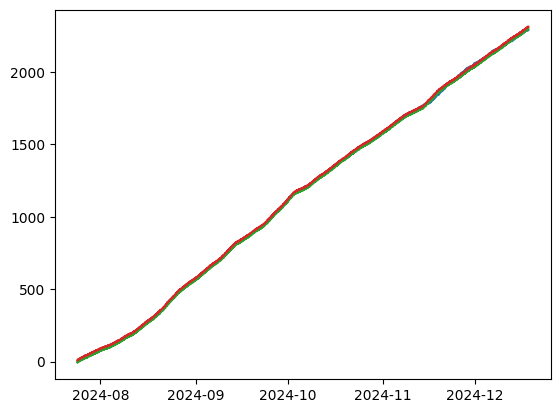

In [471]:
plt.plot(data['hist_timestamp'],data['number_tap_changes'])
plt.plot(prediction['ds'],prediction['yhat'])
plt.plot(prediction['ds'],prediction['yhat_lower'])
plt.plot(prediction['ds'],prediction['yhat_upper'])
plt.show()

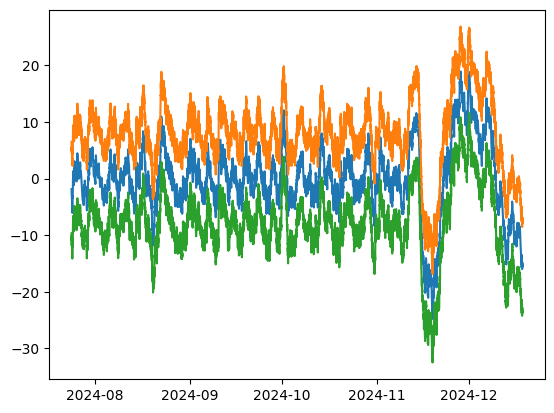

In [472]:
plt.plot(prediction['ds'],data['number_tap_changes'] - prediction['yhat'])
plt.plot(prediction['ds'],data['number_tap_changes'] - prediction['yhat_lower'])
plt.plot(prediction['ds'],data['number_tap_changes'] - prediction['yhat_upper'])
plt.show()

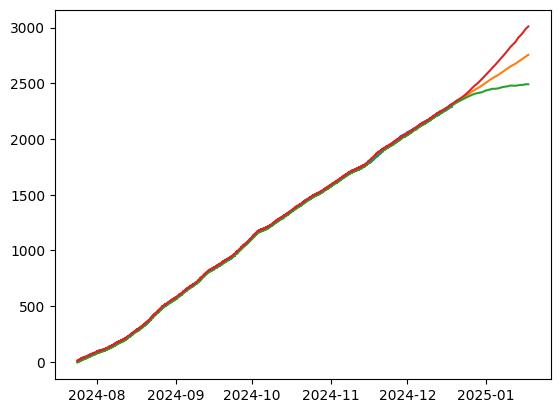

In [473]:
future = m.make_future_dataframe(periods=30)
future_prediction = m.predict(future)
plt.plot(data['hist_timestamp'],data['number_tap_changes'])
plt.plot(future_prediction['ds'],future_prediction['yhat'])
plt.plot(future_prediction['ds'],future_prediction['yhat_lower'])
plt.plot(future_prediction['ds'],future_prediction['yhat_upper'])
plt.show()